# Play with pipeline

### Import

In [1]:
import os
PROJECT_PATH = "/projects/compures/alexandre/disdiff_adapters"
os.chdir(PROJECT_PATH)
print(os.getcwd())

import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils

#DataModule
from disdiff_adapters.data_module import *
#Module
from disdiff_adapters.arch.vae import *
from disdiff_adapters.arch.multi_distillme import *
#utils
from disdiff_adapters.utils import *
#loss
from disdiff_adapters.loss import *
#metric
from disdiff_adapters.metric import *
#ext
from chada.backbones.vit.chada_vit import ChAdaViT # type: ignore

from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer

BATCH_SIZE = 32
LATENT_DIM = 64

torch.set_float32_matmul_precision('medium')

/import/pr_compures/alexandre/disdiff_adapters


/projects/compures/alexandre/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/timm/optim/optim_factory.py:7: FutureWarning: Importing from timm.optim.optim_facto

## Load data 

**Choose the appropriate set :**

### 3DShapes

In [2]:
#6mn30 from ens cluster
shapes = Shapes3DDataModule(batch_size=BATCH_SIZE)
shapes.prepare_data()
shapes.setup(stage='fit')
shapes_loader = shapes.train_dataloader()
# else :
#     images, labels = load_h5(Shapes3D.Path.H5)
#     images = images[:32]
#     labels = labels[:32]
#     shapes_loader = DataLoader(TensorDataset(torch.tensor(images).permute(0,3,1,2), torch.tensor(labels)), batch_size=8, shuffle=True)

loading of tensors - train
loading of tensors - val
load dataset - train
load dataset val
tensors loaded.


In [3]:
print(len(shapes.train_dataset))

307200


In [ ]:
for batch in shapes_loader :
    images, labels = batch
    print(images.shape)
    break

torch.Size([8, 3, 64, 64])


### BloodMNIST

In [2]:
blood = BloodMNISTDataModule(batch_size=BATCH_SIZE)
blood.prepare_data()
blood.setup("fit")
blood_loader = blood.train_dataloader()

In [3]:
len(blood.train_dataset)

9567

### CelebA

In [3]:
celeba = CelebADataModule(batch_size=BATCH_SIZE)
celeba.prepare_data()
celeba.setup("fit")
celeba_loader = celeba.train_dataloader()

In [4]:
len(celeba.train_dataset)

162770

### Choose the correct loader

In [4]:
loader = blood_loader
stop_at = 0

for i,batch in enumerate(loader) :
    images, labels = batch
    in_channels = images.shape[1]
    img_size = images.shape[2]
    if i == stop_at : break
    
print(f"Data selected with in_channels={in_channels} and img_size={img_size}")
toy_loader = DataLoader(TensorDataset(torch.cat(2*[images]), torch.cat(2*[labels])), batch_size=2*32)

Data selected with in_channels=3 and img_size=28


## VAE

### Variational Encoder

Let's display the PCA-latent space with VAE encoder

In [4]:
encoder = Encoder(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)

encoder.eval()
mus = []
logvars = []
labels = []

for i,batch in enumerate(loader) :
    image, label = batch

    mu, logvar = encoder(image)

    mus.append(mu)
    logvars.append(logvar)
    labels.append(label)
    if (stop_at is not None) and (stop_at == i) : break

try :
    mus = torch.cat(mus)
    logvars = torch.cat(logvars)
    labels = torch.cat(labels)
except TypeError as e : print("!!You have already run this cell.!!")
print(f"labels shape = {labels.shape}")

labels shape = torch.Size([32, 40])


Make sure that labels shape is at [Batch size, 1]. Preprocess here if needed :

In [13]:
labels[:, 0].unsqueeze(1).shape

torch.Size([32, 1])

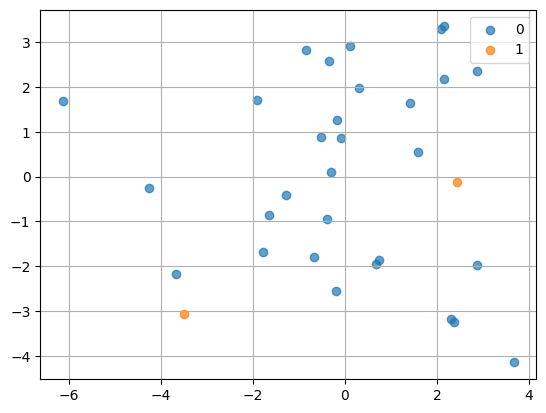

In [5]:
assert labels[:, 0].unsqueeze(1).shape == (labels.shape[0], 1), "You have to preprocess labels before using pca_latent display function"
pca_latent(labels=labels[:, 0].unsqueeze(1), mu_logvars=(mus, logvars))

In [6]:
print(encoder.flattened_size, encoder.out_encoder_shape)

16384 torch.Size([256, 8, 8])


### Decoder

In [7]:
#Sample latent
z = sample_from((mus, logvars))
print(f"Latent space is a {z.shape}")
decoder = Decoder(out_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, out_encoder_shape=encoder.out_encoder_shape)
x_hat_logits = decoder(z)
try: assert x_hat_logits.shape == (x_hat_logits.shape[0], in_channels, img_size, img_size)
except AssertionError as e : 
    print(x_hat_logits.shape)
    print("!!!!WARNING : reconstruction error : output of the decoder must be with the a same shape as the input")

Latent space is a torch.Size([32, 64])


In [8]:
x_hat_logits.shape

torch.Size([32, 3, 64, 64])

tensor(-0.9836, grad_fn=<MinBackward1>) tensor(0.9831, grad_fn=<MaxBackward1>)


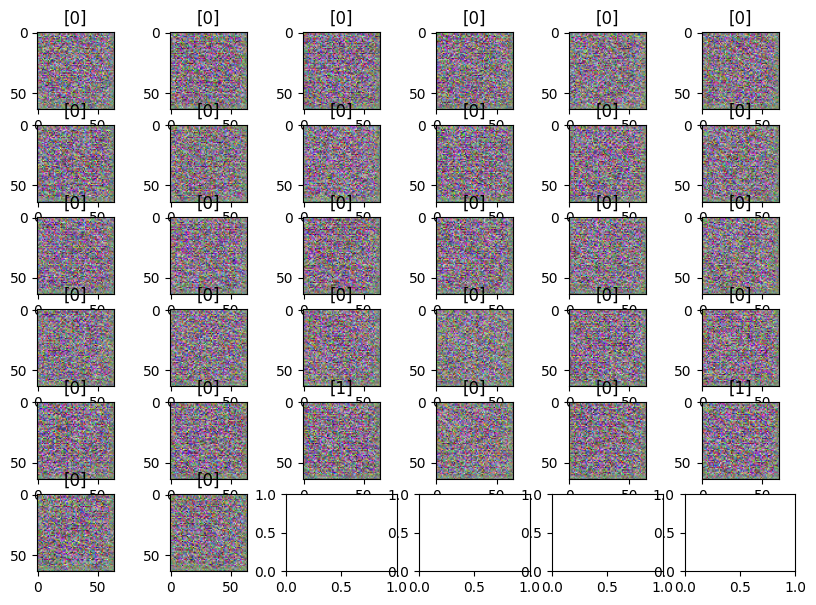

In [9]:
assert x_hat_logits.shape==image.shape, "shape error"
print(x_hat_logits.min(), x_hat_logits.max())
display((x_hat_logits, labels[:, 0].unsqueeze(1)))
loss_mse = mse(x_hat_logits, image)
loss_kl = kl(*(mus, logvars))

### VAE - train

In [5]:
batch = next(iter(loader))
images, labels = batch
images.shape
images.min()

tensor(-0.9765)

Prior to any train :

Sanity check : torch.Size([32, 3, 28, 28])


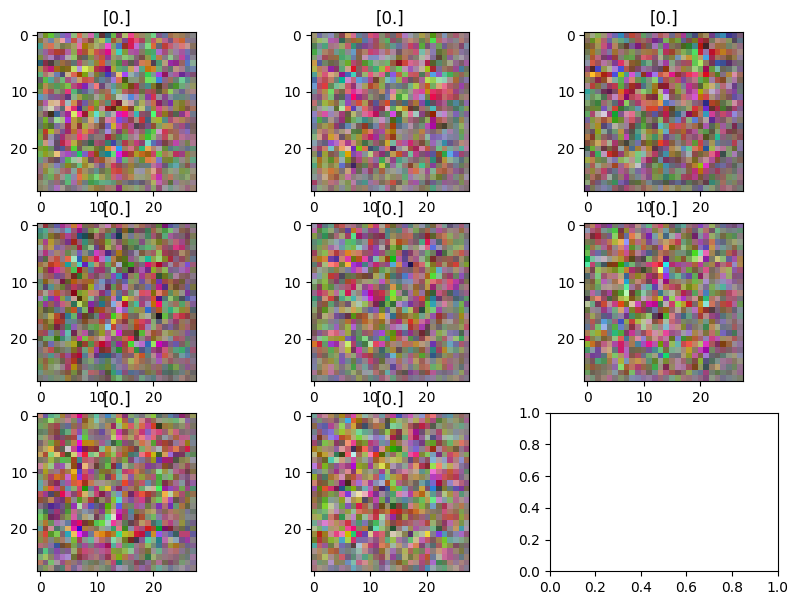

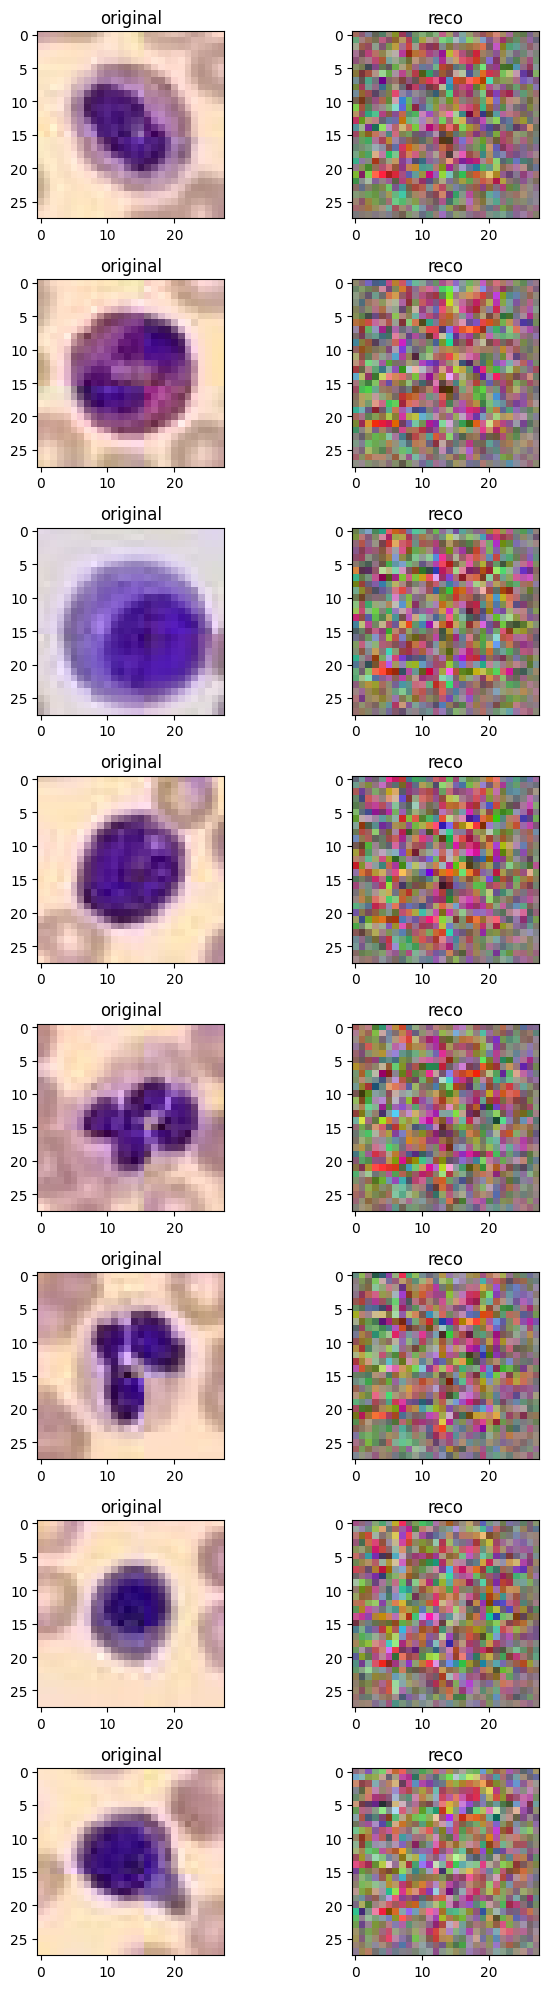

In [6]:
beta=0
vae = VAEModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, beta=beta, warm_up=False)
image_hat_logits = vae(images)
print(f"Sanity check : {image_hat_logits[0].shape}")
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

In [11]:
max_epoch=50
trainer = Trainer(
        accelerator="auto",
        devices=-1,
        max_epochs=max_epoch,

        logger=TensorBoardLogger(
            save_dir=PROJECT_PATH+"disdiff_adapters/notebook/",
            version="cur",
            default_hp_metric=False,
            )
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(vae, loader)

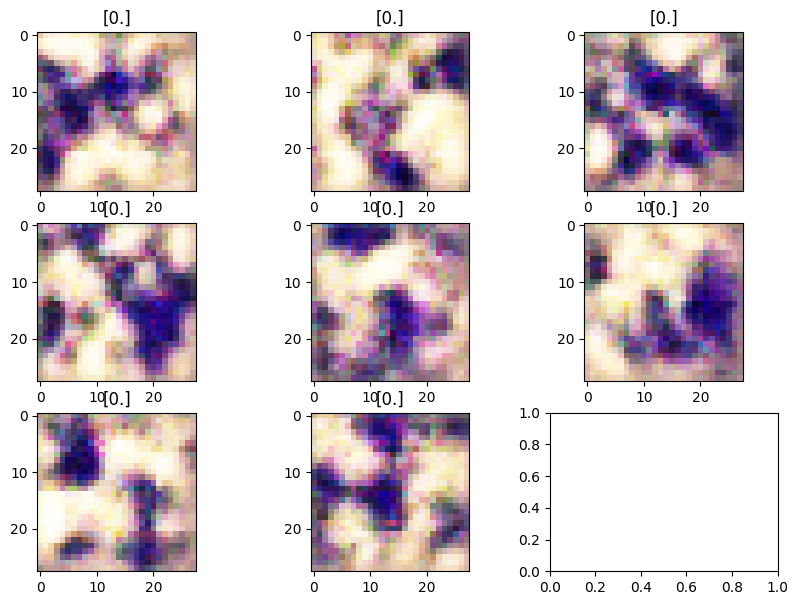

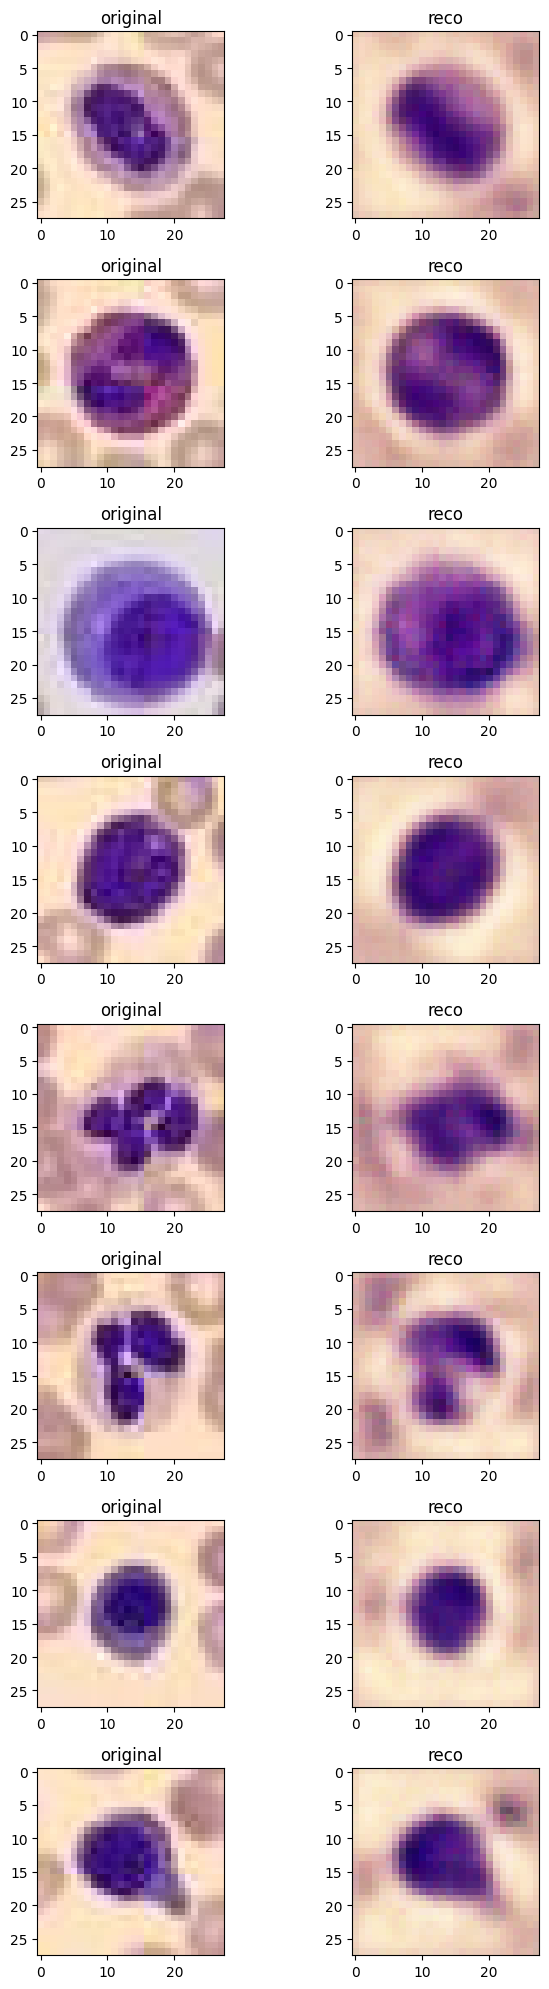

In [13]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

Then with beta at 10 :

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity check : torch.Size([32, 3, 28, 28])


/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
------------------------------------------

Epoch 0:   0%|          | 0/99 [00:00<?, ?it/s] Train loss: 0.4501899778842926
Train loss: 0.4417465627193451
Train loss: 0.4499157965183258
Epoch 0:   1%|          | 1/99 [00:00<00:57,  1.70it/s, v_num=cur]Train loss: 0.43425658345222473
Train loss: 0.4488674998283386
Epoch 0:   2%|▏         | 2/99 [00:00<00:29,  3.26it/s, v_num=cur]Train loss: 0.4440261721611023
Train loss: 0.43793579936027527
Train loss: 0.46358734369277954
Epoch 0:   3%|▎         | 3/99 [00:00<00:21,  4.56it/s, v_num=cur]Train loss: 0.4382920265197754
Train loss: 0.440986305475235Train loss: 0.4485325813293457Train loss: 0.4538830816745758


Epoch 0:   4%|▍         | 4/99 [00:00<00:16,  5.75it/s, v_num=cur]Train loss: 0.4556787312030792
Train loss: 0.4491245746612549
Epoch 0:   5%|▌         | 5/99 [00:00<00:13,  6.97it/s, v_num=cur]Train loss: 0.4606500267982483
Train loss: 0.4488856792449951
Train loss: 0.42154568433761597Train loss: 0.4441065490245819

Epoch 0:   6%|▌         | 6/99 [00:00<00:11,  8.03it/s, v_num

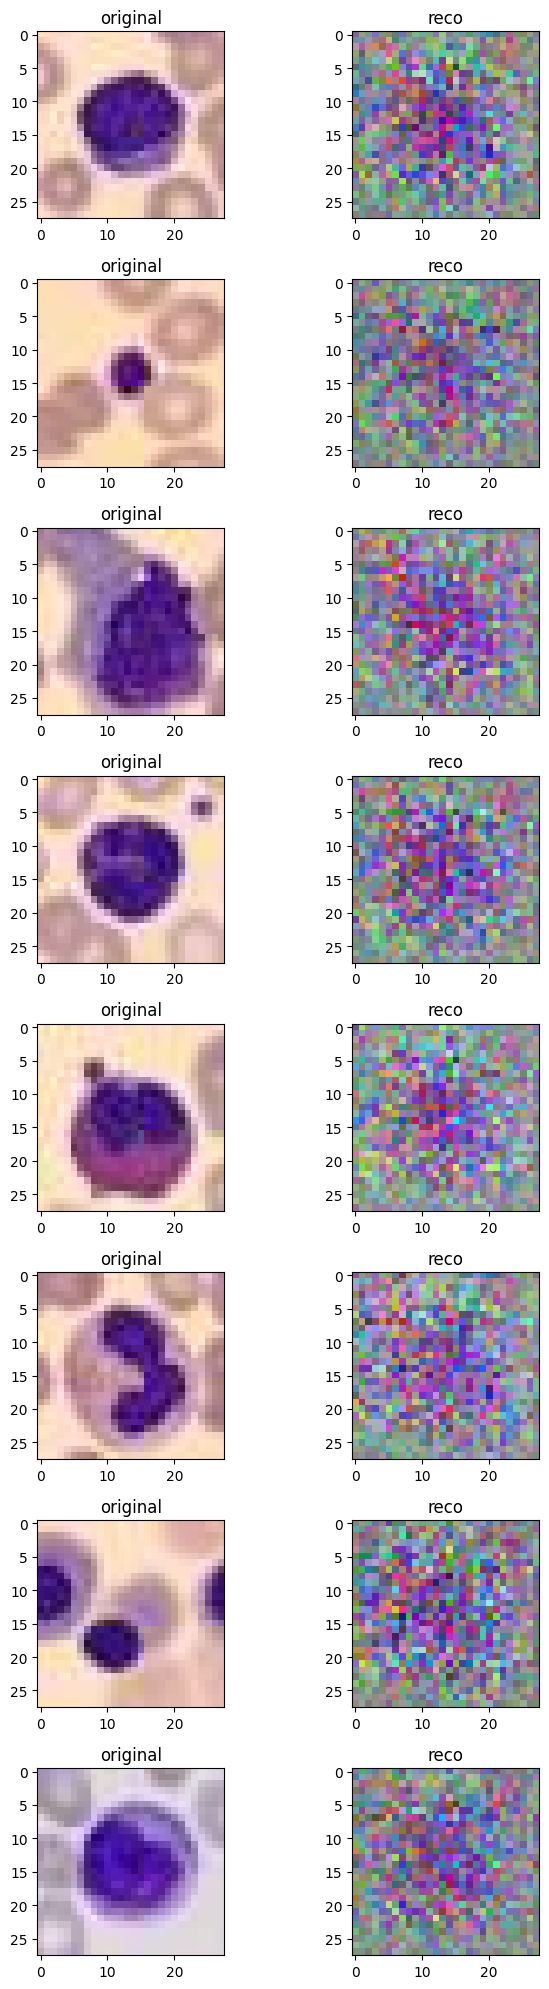

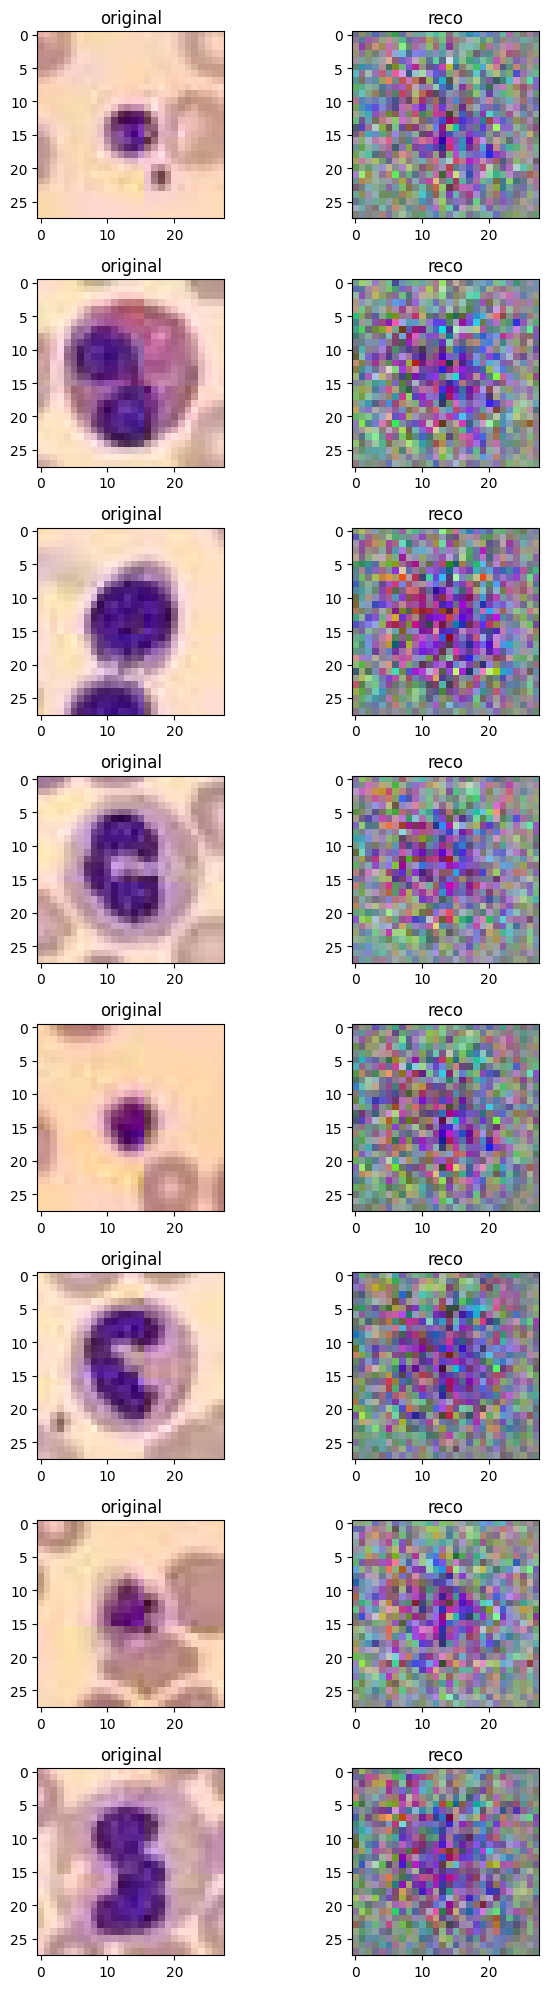

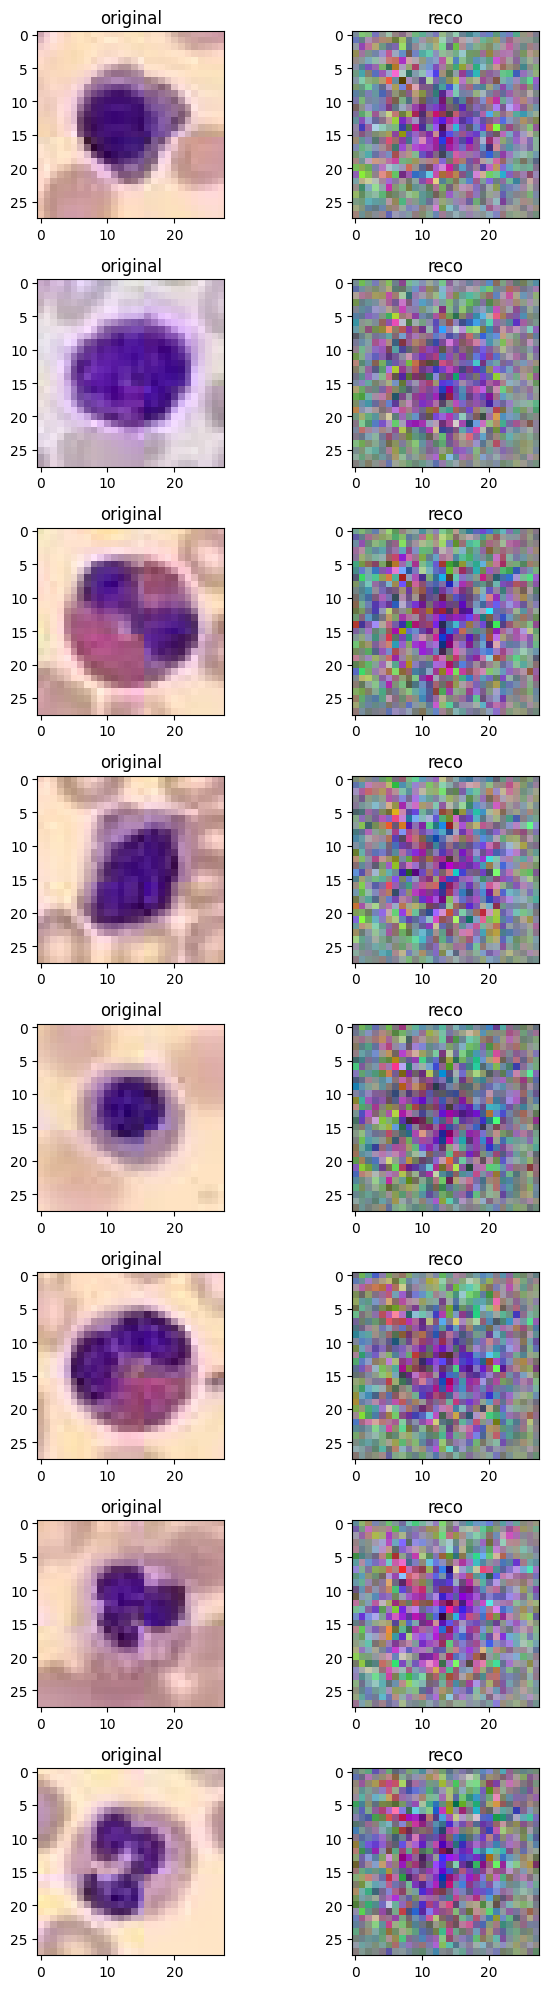

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s, v_num=cur]         Train loss: 0.3678136467933655Train loss: 0.34970784187316895

Train loss: 0.36650413274765015
Epoch 1:   1%|          | 1/99 [00:01<03:13,  0.51it/s, v_num=cur]Train loss: 0.3623347282409668
Train loss: 0.36940354108810425
Epoch 1:   2%|▏         | 2/99 [00:02<01:38,  0.99it/s, v_num=cur]Train loss: 0.37681844830513
Train loss: 0.3493518531322479Train loss: 0.3591022789478302

Train loss: 0.3627673387527466
Epoch 1:   3%|▎         | 3/99 [00:02<01:07,  1.43it/s, v_num=cur]Train loss: 0.34863707423210144Train loss: 0.3593737781047821
Train loss: 0.3607714772224426

Epoch 1:   4%|▍         | 4/99 [00:02<00:50,  1.88it/s, v_num=cur]Train loss: 0.36885854601860046
Train loss: 0.3666135370731354Train loss: 0.36587586998939514

Epoch 1:   5%|▌         | 5/99 [00:02<00:40,  2.33it/s, v_num=cur]Train loss: 0.35201993584632874
Train loss: 0.35700035095214844Train loss: 0.3572298288345337

Epoch 1:   6%|▌         | 6/99 [00:02<0

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

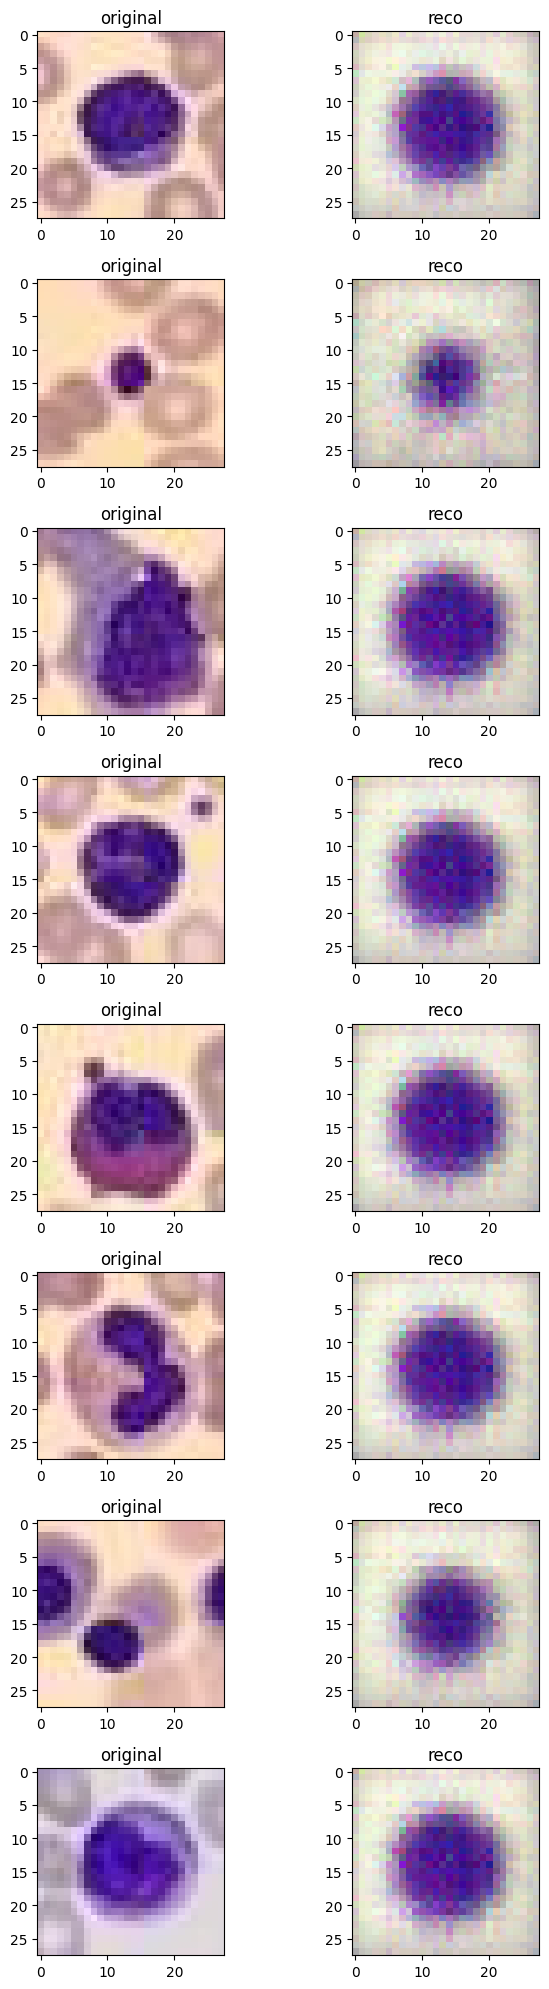

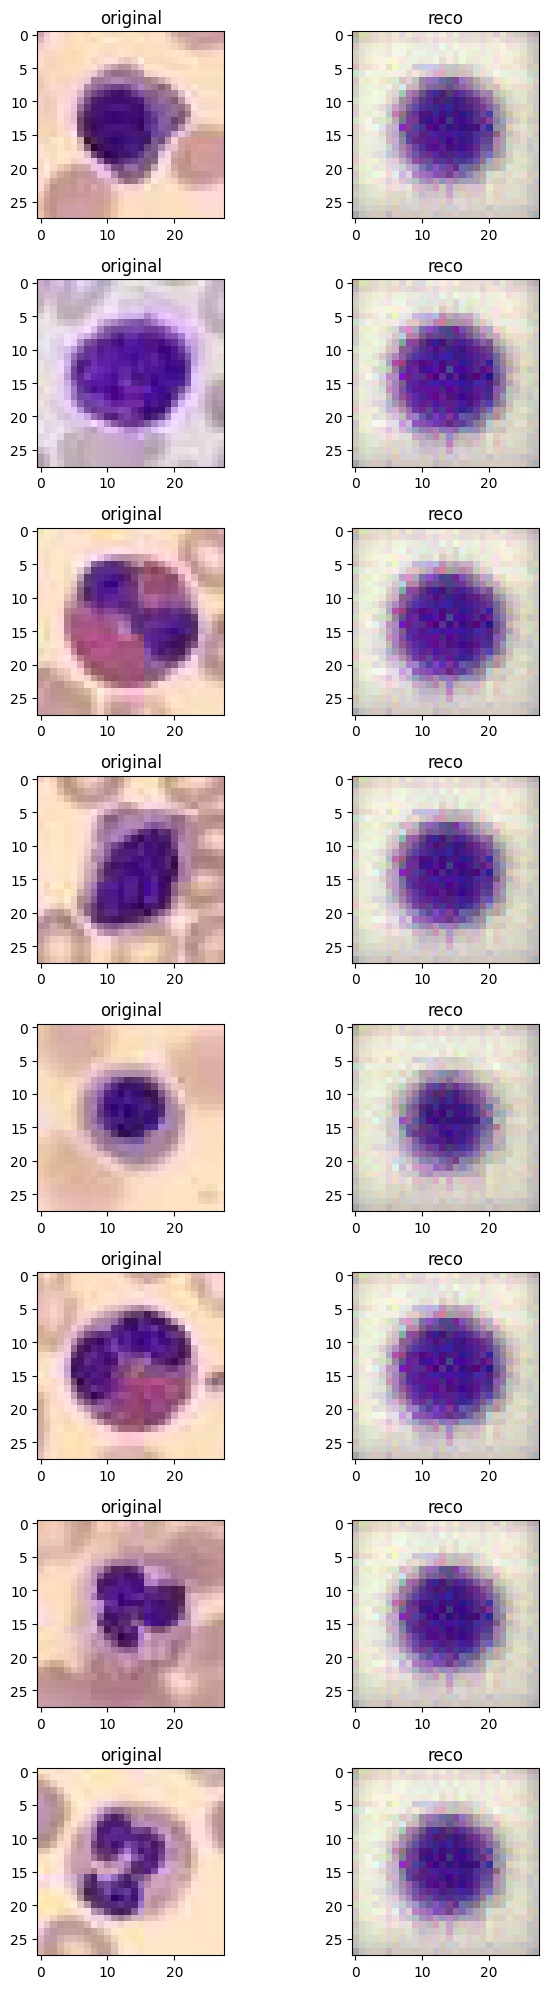

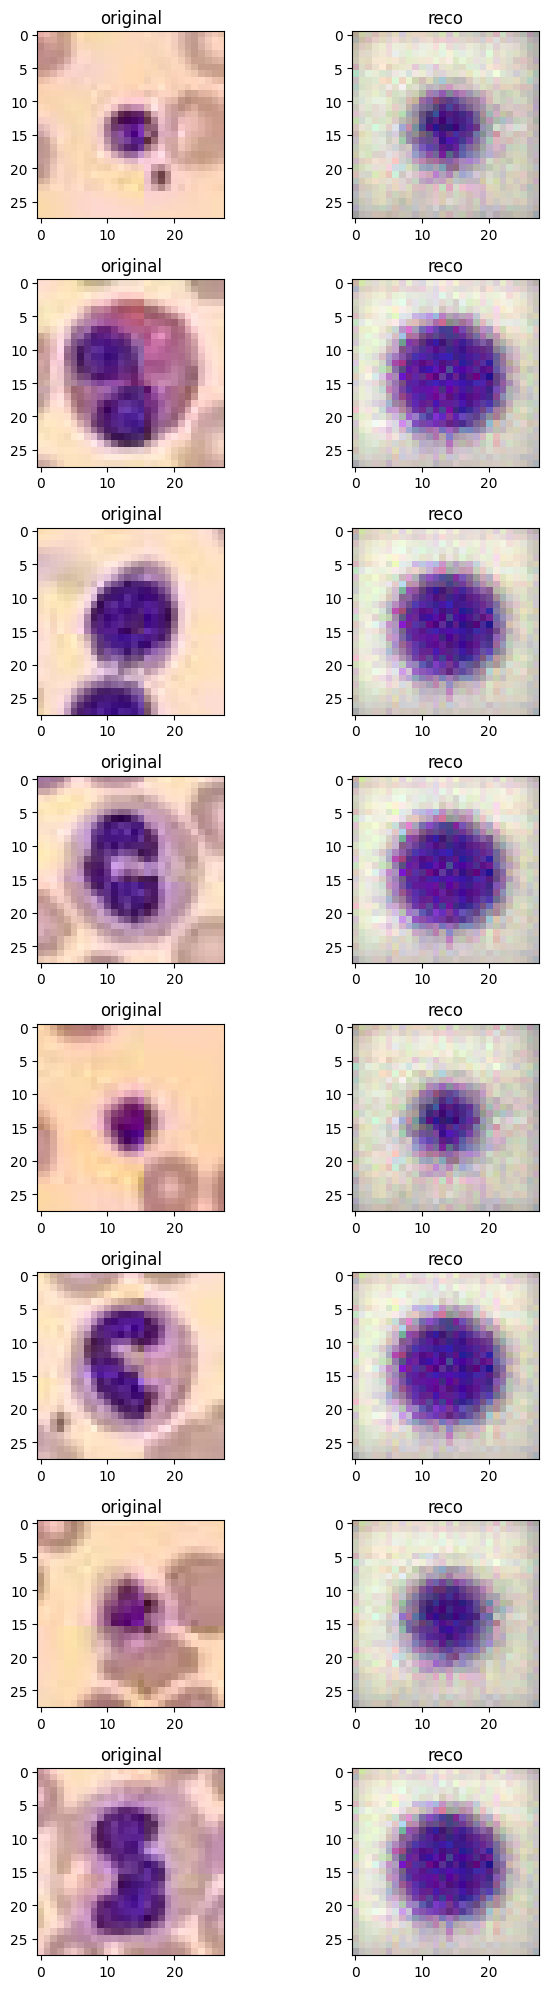

Epoch 11:   0%|          | 0/99 [00:00<?, ?it/s, v_num=cur]         Train loss: 0.11425808817148209Train loss: 0.12028886377811432

Train loss: 0.11620166897773743
Epoch 11:   1%|          | 1/99 [00:01<03:15,  0.50it/s, v_num=cur]Train loss: 0.12715598940849304Train loss: 0.13291940093040466

Train loss: 0.12407088279724121
Epoch 11:   2%|▏         | 2/99 [00:02<01:38,  0.99it/s, v_num=cur]Train loss: 0.11895323544740677Train loss: 0.11765676736831665

Epoch 11:   3%|▎         | 3/99 [00:02<01:05,  1.46it/s, v_num=cur]Train loss: 0.1229882761836052
Train loss: 0.11533094942569733
Train loss: 0.12177774310112
Train loss: 0.12415630370378494
Epoch 11:   4%|▍         | 4/99 [00:02<00:49,  1.92it/s, v_num=cur]Train loss: 0.12366649508476257Train loss: 0.12155193090438843

Train loss: 0.11961078643798828
Epoch 11:   6%|▌         | 6/99 [00:02<00:33,  2.80it/s, v_num=cur]Train loss: 0.12124726176261902
Train loss: 0.10928329825401306
Train loss: 0.11971048265695572Train loss: 0.141821682453

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

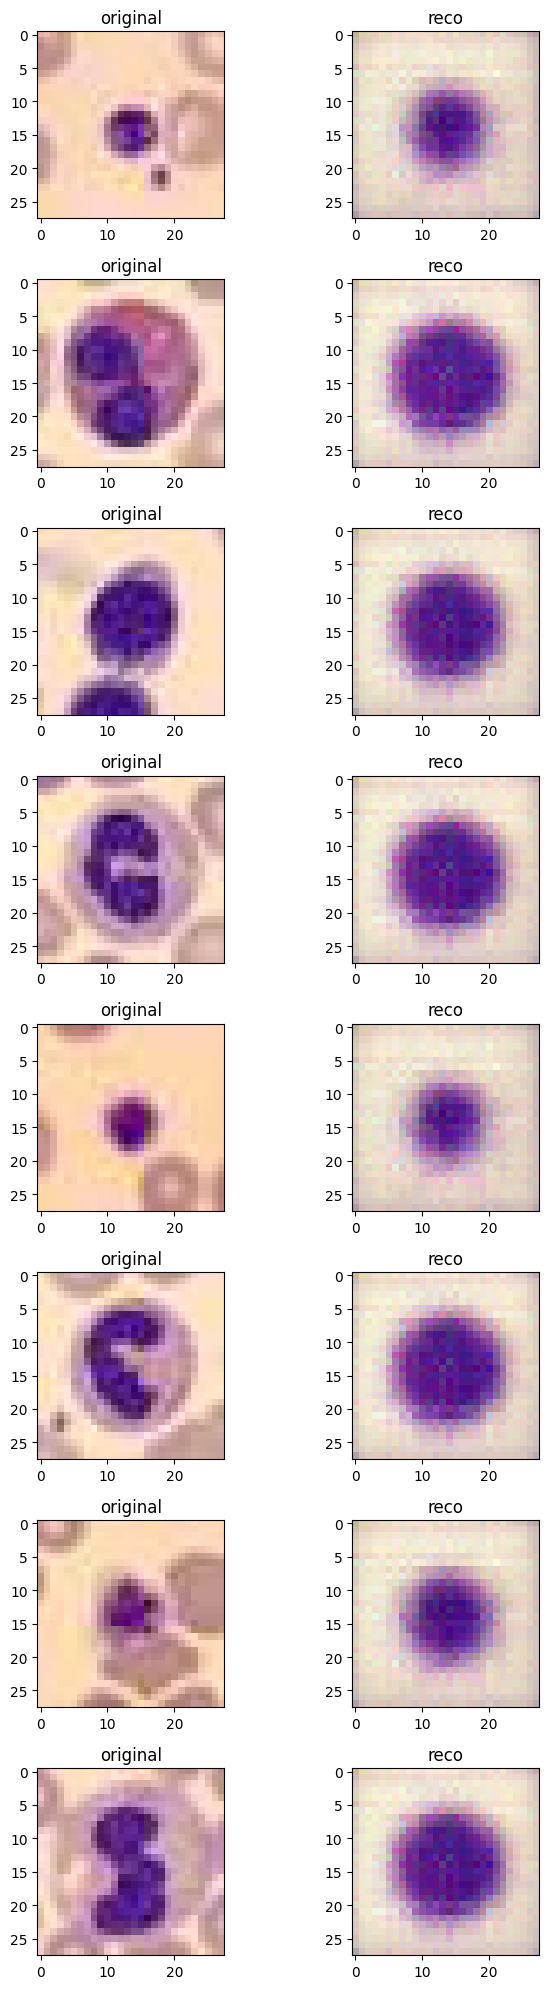

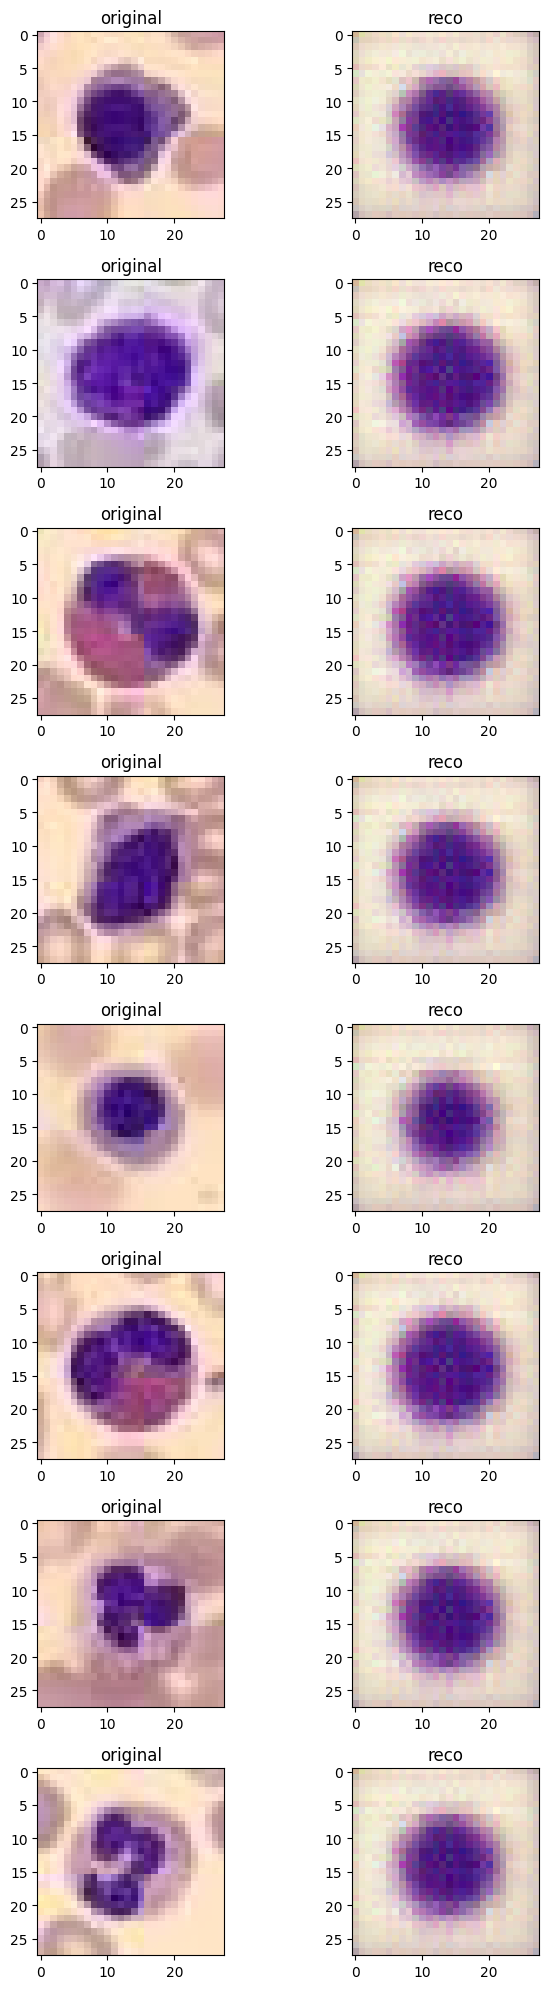

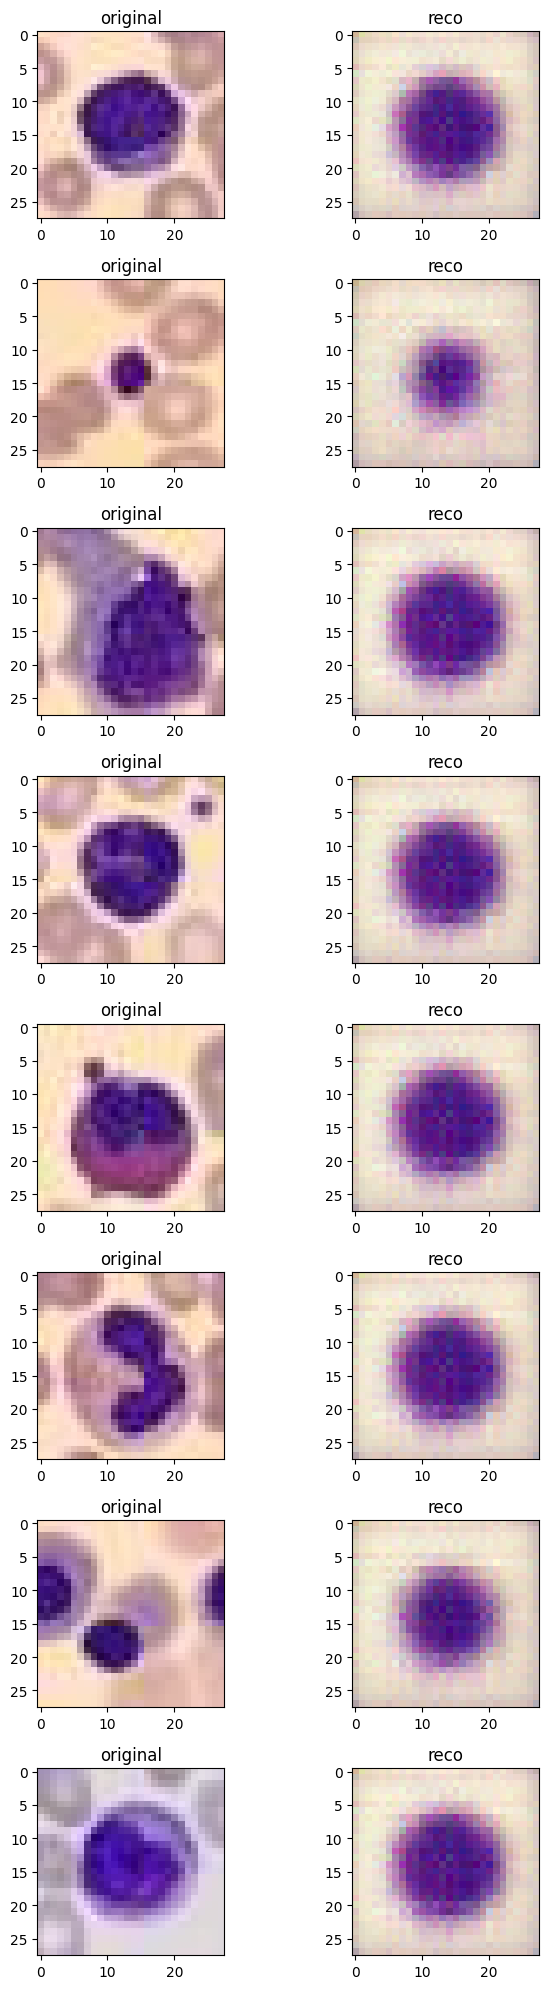

Epoch 21:   1%|          | 1/99 [00:01<03:02,  0.54it/s, v_num=cur]Train loss: 0.09584536403417587
Train loss: 0.09275103360414505
Train loss: 0.10593228042125702
Train loss: 0.0952531099319458
Epoch 21:   2%|▏         | 2/99 [00:02<01:37,  0.99it/s, v_num=cur]Train loss: 0.11806446313858032
Train loss: 0.09270738810300827
Train loss: 0.0977892279624939
Train loss: 0.09238064289093018
Epoch 21:   3%|▎         | 3/99 [00:02<01:05,  1.47it/s, v_num=cur]Train loss: 0.09064838290214539Train loss: 0.08982052654027939

Train loss: 0.1017720103263855
Epoch 21:   5%|▌         | 5/99 [00:02<00:39,  2.39it/s, v_num=cur]Train loss: 0.09470069408416748Train loss: 0.09348423033952713

Train loss: 0.09579978138208389
Train loss: 0.09491357207298279Train loss: 0.09326084703207016

Epoch 21:   6%|▌         | 6/99 [00:02<00:33,  2.80it/s, v_num=cur]Train loss: 0.09069138020277023Train loss: 0.09931037575006485

Train loss: 0.08387117087841034
Epoch 21:   7%|▋         | 7/99 [00:02<00:28,  3.23it/s, v_n

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

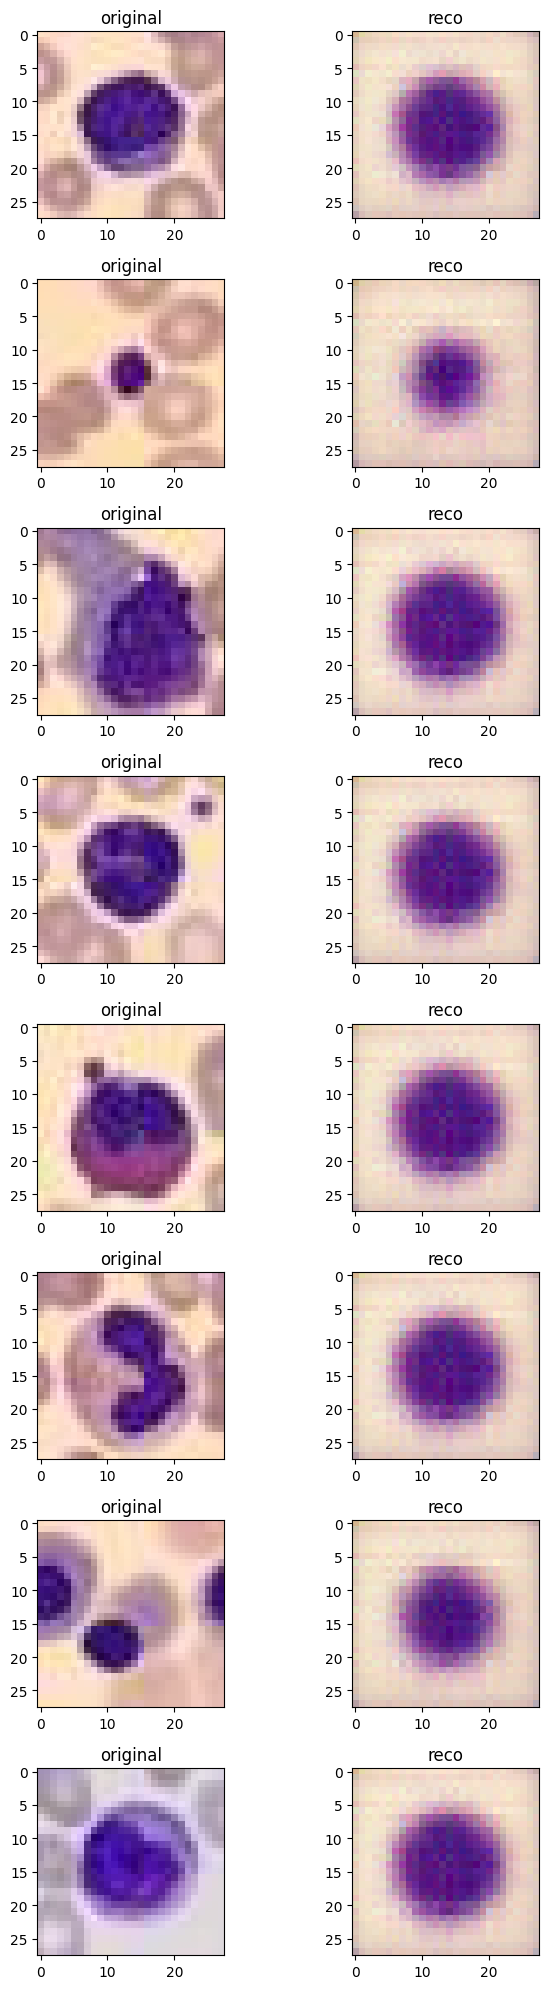

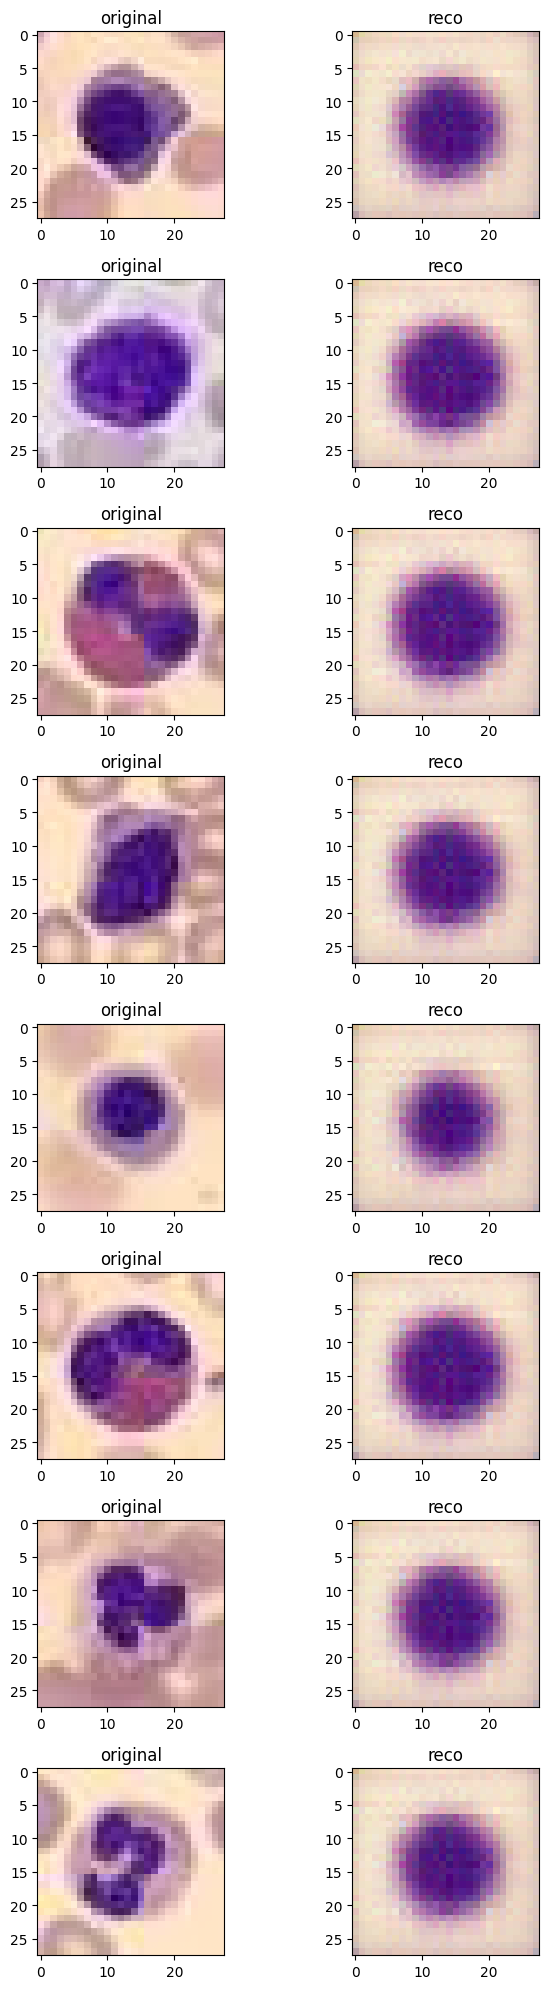

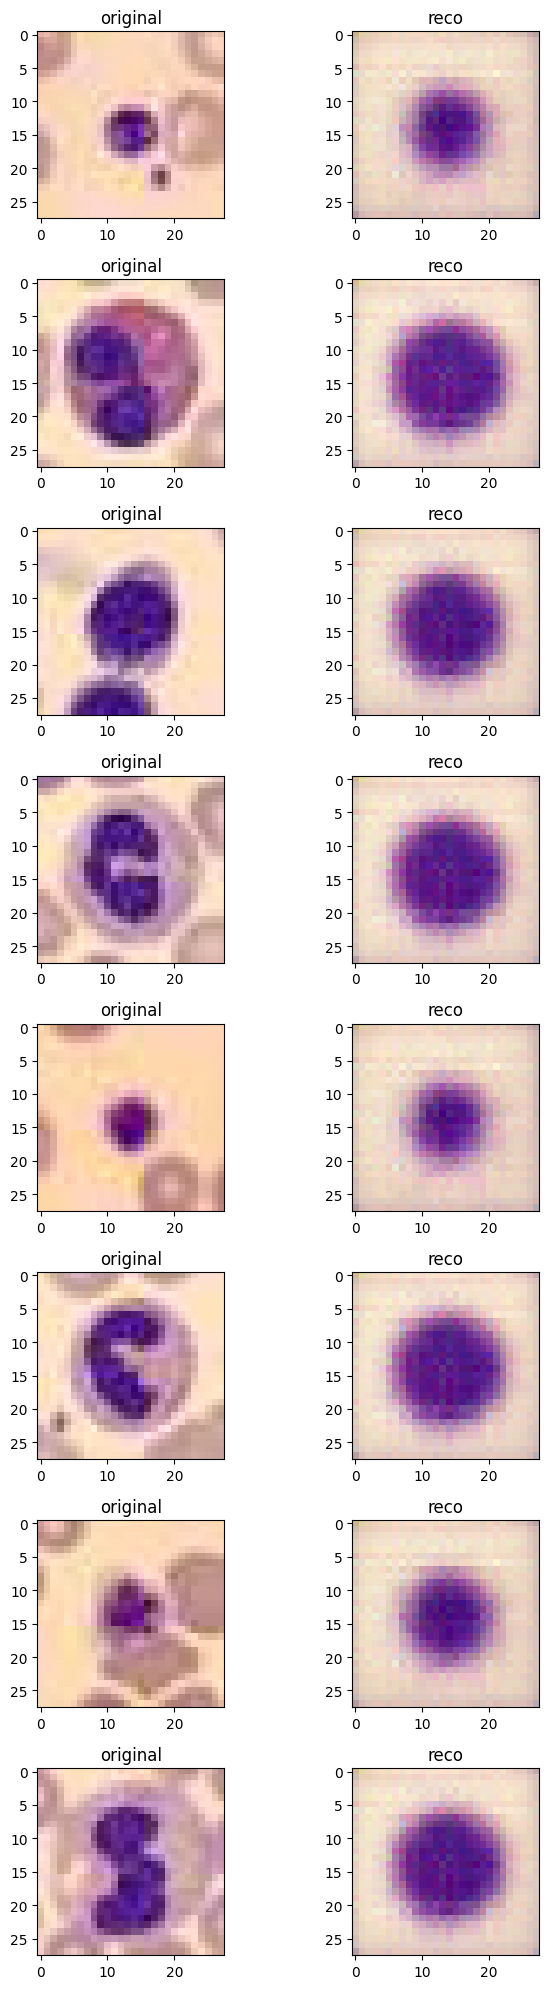

Epoch 31:   1%|          | 1/99 [00:01<03:06,  0.53it/s, v_num=cur]Train loss: 0.08939843624830246
Train loss: 0.09311999380588531
Train loss: 0.08966691792011261
Train loss: 0.08439396321773529
Epoch 31:   2%|▏         | 2/99 [00:01<01:36,  1.00it/s, v_num=cur]Train loss: 0.09309452772140503
Train loss: 0.08969372510910034Train loss: 0.09397666156291962

Epoch 31:   3%|▎         | 3/99 [00:02<01:04,  1.49it/s, v_num=cur]Train loss: 0.08578724414110184
Train loss: 0.08673427999019623
Epoch 31:   4%|▍         | 4/99 [00:02<00:48,  1.95it/s, v_num=cur]Train loss: 0.09102781862020493
Train loss: 0.0918896347284317
Train loss: 0.10357829183340073Train loss: 0.09342678636312485

Epoch 31:   5%|▌         | 5/99 [00:02<00:39,  2.40it/s, v_num=cur]Train loss: 0.08868919312953949
Train loss: 0.07987087219953537
Train loss: 0.08521098643541336
Epoch 31:   6%|▌         | 6/99 [00:02<00:32,  2.85it/s, v_num=cur]Train loss: 0.07882365584373474Train loss: 0.08205036073923111

Train loss: 0.087605893

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

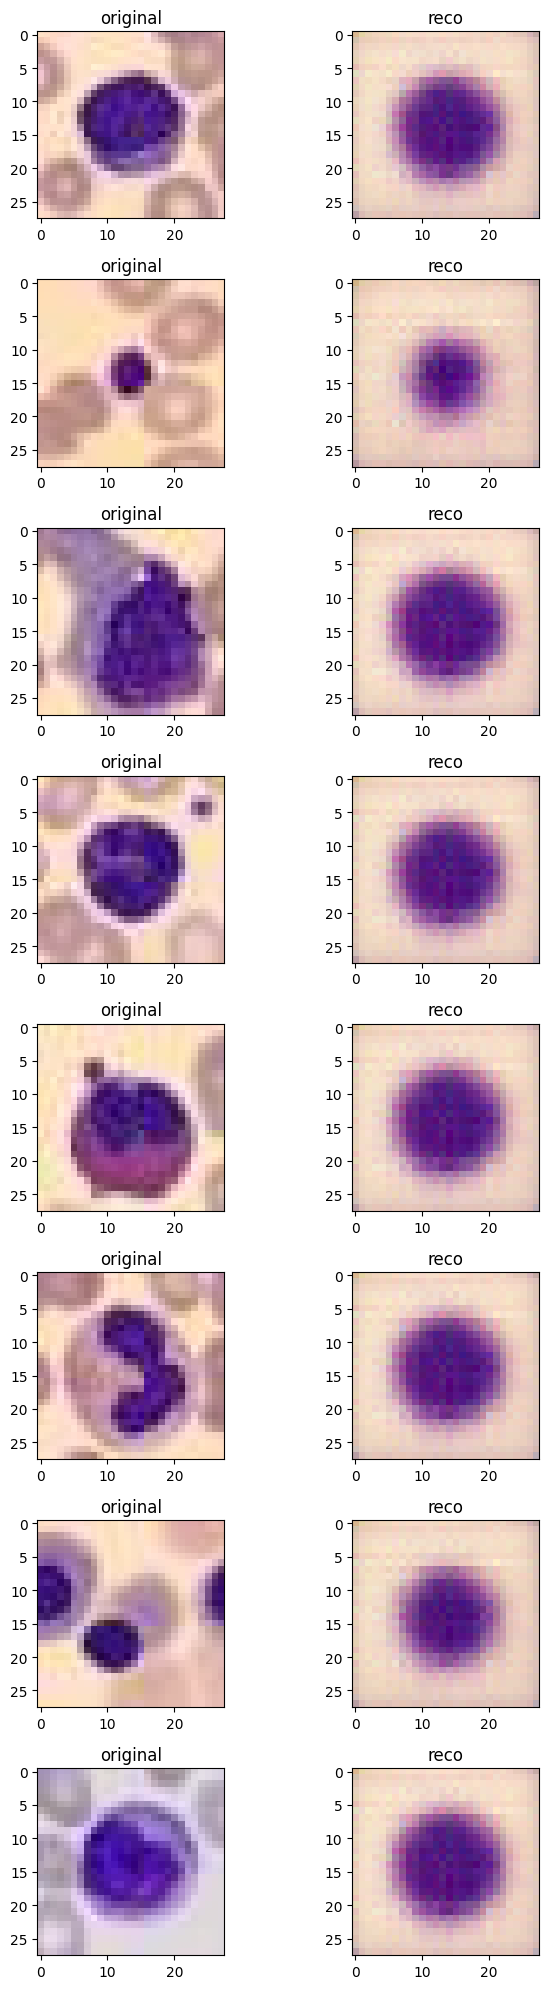

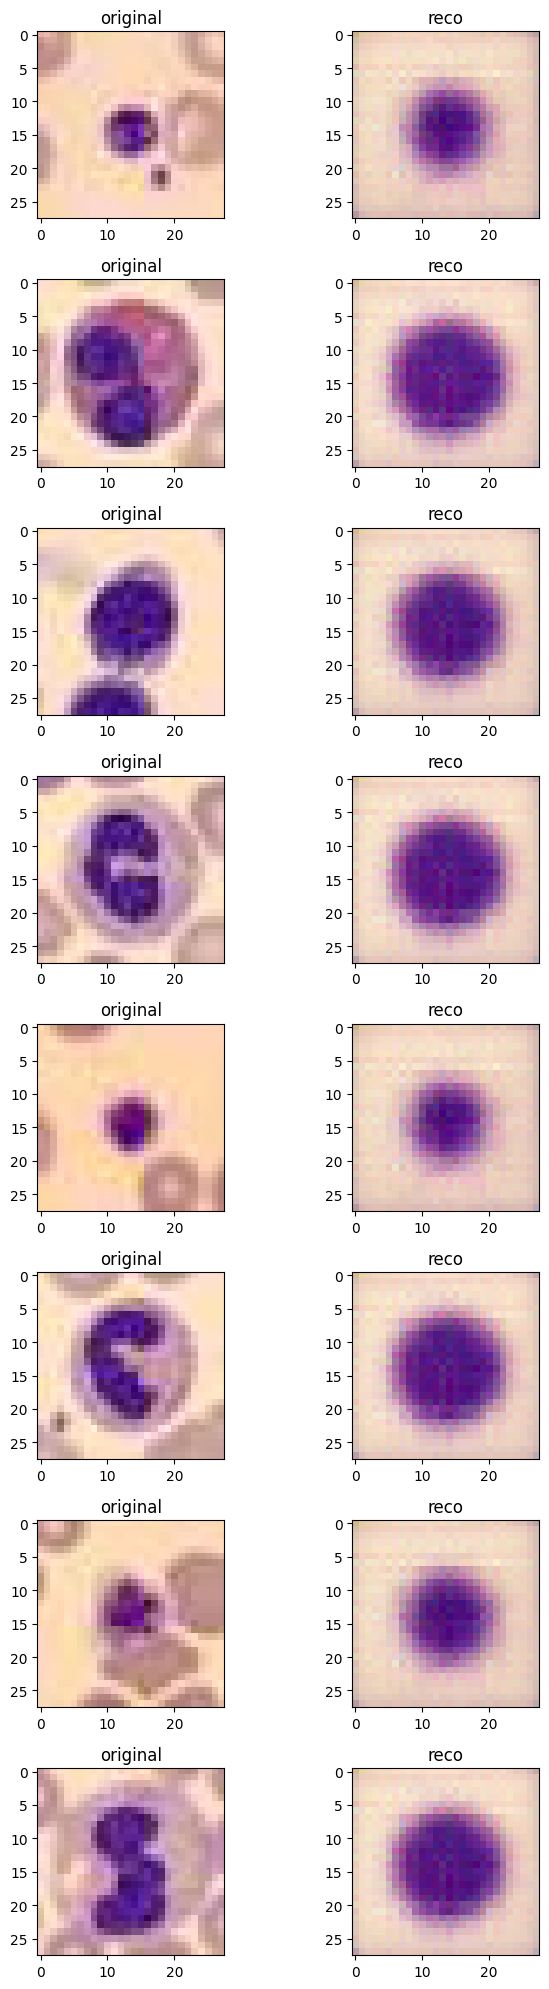

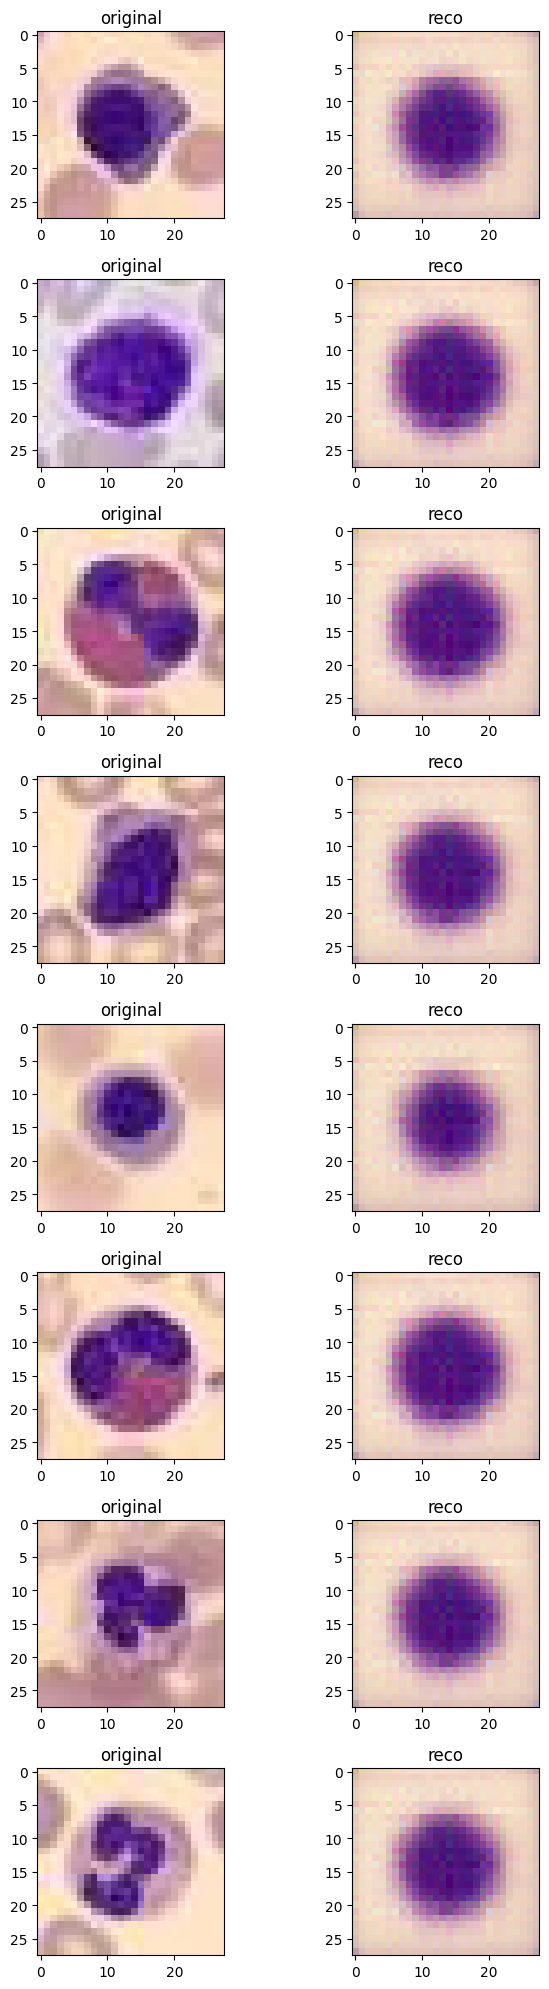

Epoch 41:   1%|          | 1/99 [00:01<03:13,  0.51it/s, v_num=cur]Train loss: 0.0909619927406311
Train loss: 0.09131458401679993
Train loss: 0.08348283171653748
Epoch 41:   2%|▏         | 2/99 [00:02<01:39,  0.97it/s, v_num=cur]Train loss: 0.08135328441858292
Train loss: 0.08605068176984787
Train loss: 0.08687007427215576Train loss: 0.10447704792022705

Train loss: 0.08772004395723343
Epoch 41:   3%|▎         | 3/99 [00:02<01:06,  1.44it/s, v_num=cur]Train loss: 0.08187597990036011
Train loss: 0.08562859147787094Train loss: 0.07844123244285583

Epoch 41:   4%|▍         | 4/99 [00:02<00:50,  1.89it/s, v_num=cur]Train loss: 0.08729559183120728Train loss: 0.07822220027446747Train loss: 0.08898115903139114


Epoch 41:   5%|▌         | 5/99 [00:02<00:40,  2.34it/s, v_num=cur]Train loss: 0.08631069958209991Train loss: 0.09552447497844696

Train loss: 0.09427982568740845
Epoch 41:   6%|▌         | 6/99 [00:02<00:33,  2.78it/s, v_num=cur]Train loss: 0.08501146733760834
Train loss: 0.087007276

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 99/99 [00:04<00:00, 21.86it/s, v_num=cur]


In [ ]:
beta=20
vae = VAEModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, beta=beta, kl_weights=0.0001)
image_hat_logits = vae(images)
print(f"Sanity check : {image_hat_logits[0].shape}")

max_epoch=50
trainer = Trainer(
        accelerator="auto",
        devices=[1,2,3],
        max_epochs=max_epoch,

        logger=TensorBoardLogger(
            save_dir=PROJECT_PATH+"disdiff_adapters/notebook/",
            version="cur",
            default_hp_metric=False,
            )
    )
trainer.fit(vae, loader)

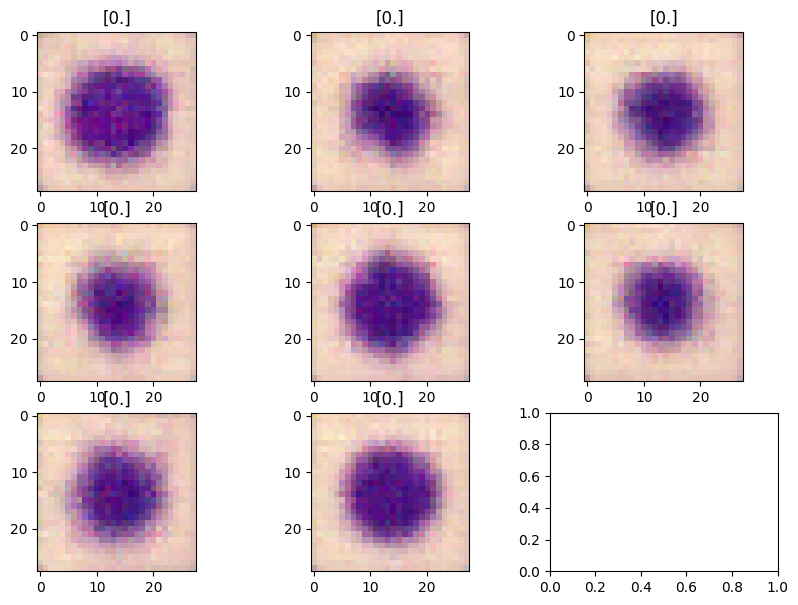

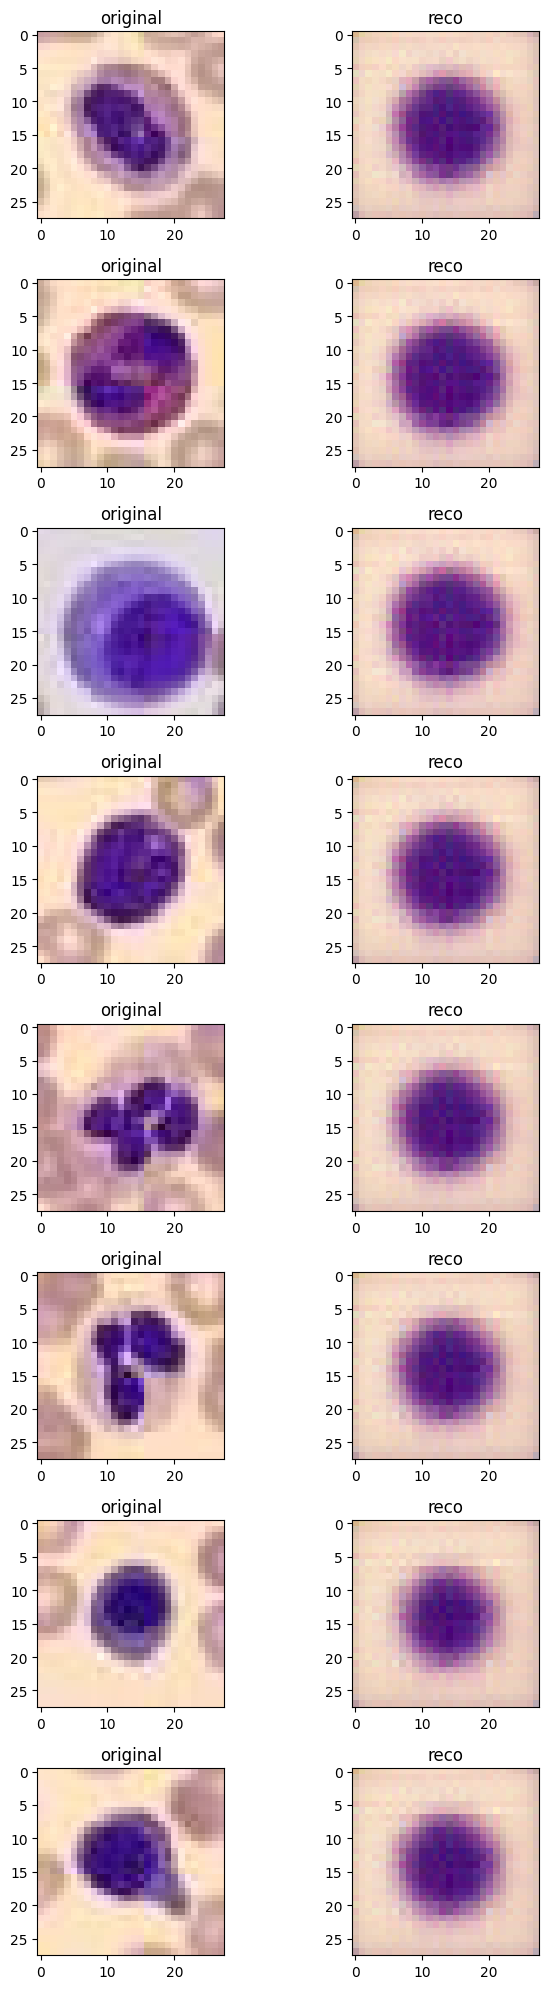

In [28]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

#### [DEBUG VAE]

##### Test - loss

In [ ]:
#kl test
mu = torch.tensor([[0,0,0,0]])
logvar = torch.tensor([[0, 0, 0, 0]])
kl_loss = kl(mu, logvar)
assert abs(kl_loss - 0.0) < 10e-3, "Error in kl implementation"
print(f"kl ok. kl={kl_loss}")

#mse test
k=2
images_hat_logits = torch.zeros([1, 3, 28, 28])
images = k*torch.ones([1, 3, 28, 28])
mse_loss = mse(images_hat_logits, images)
assert abs(mse_loss-k**2) < 10e-3
print(f"mse ok. mse={mse_loss}")

kl ok. kl=0.0
mse ok. mse=4.0


In [ ]:
test = torch.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/bloodmnist/bloodmnist_test.pt")

In [ ]:
test[0].shape

torch.Size([3421, 3, 28, 28])

##### Auto Encoder (VAE without sampling and only reco loss)

In [ ]:
ae = AEModule.load_from_checkpoint("disdiff_adapters/logs/ae/shapes/ae_epoch=10_beta=1.0_latent=128/checkpoints/epoch=9-step=384000.ckpt")

In [1]:
ae.show_reconstruct(images)

NameError: name 'ae' is not defined

## Multi-Distillme

From "load data" images.shape=torch.Size([8, 3, 28, 28])
28 is not a power of 2. Interpolation from this shape to (torch.Size([192, 4, 4]), torch.Size([192, 4, 4]))


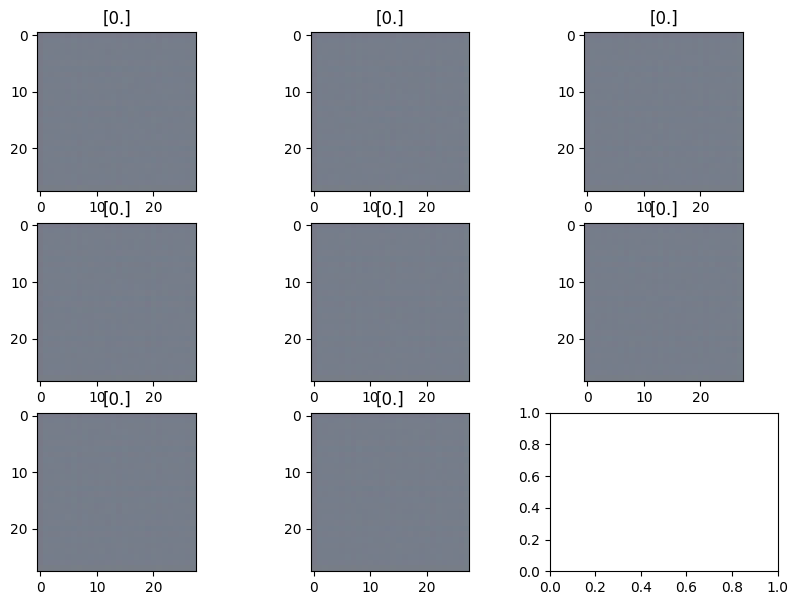

In [ ]:
multi_dm = MultiDistillMeModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)
print(f"From \"load data\" images.shape={images.shape}")

images_gen = multi_dm.generate()
labels_gen = torch.zeros([images_gen.shape[0],1])
display((images_gen, labels_gen))

In [ ]:
import torch
from lightning import LightningModule

from disdiff_adapters.arch.vae import *
from disdiff_adapters.utils import sample_from, pca_latent, display
from disdiff_adapters.loss import *


class _MultiDistillMe(torch.nn.Module) : 
    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int) :
        
        super().__init__()

        self.encoder_s = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim)
        
        self.encoder_t = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim)
        
        self.merge_operation = torch.add
        
        self.decoder = Decoder(out_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim,
                               out_encoder_shape=self.encoder_s.out_encoder_shape)
        
        self.labels_buff = []
        self.latent_buff = []
        
    def forward(self, images: torch.Tensor) :

        #forward t
        mus_logvars_s = self.encoder_s(images)
        z_s = sample_from(mus_logvars_s)

        #forward_t
        mus_logvars_t = self.encoder_t(images)
        z_t = sample_from(mus_logvars_t)

        #merge latent vector from s and t
        z = self.merge_operation(z_s, z_t)

        #decoder
        image_hat_logits = self.decoder(z)

        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
class MultiDistillMeDataModule(LightningModule) :

    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int,
                 beta_s: float=1.0,
                 beta_t: float=1.0) :
        
        super().__init__()
        self.save_hyperparameters()

        self.model = _MultiDistillMe(in_channels=self.hparams.in_channels,
                                     img_size=self.hparams.img_size,
                                     latent_dim=self.hparams.latent_dim,)
            
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters())
    
    def generate(self, nb_samples: int=8) :
        eps_s = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim]))
        eps_t = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim]))
        z = self.model.merge_operation(eps_s, eps_t)

        x_hat_logits = self.model.decoder(z)
        return x_hat_logits
    
    def forward(self, images: torch.Tensor) :
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.model(images)
        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
    def loss(self, mus_logvars_s, mus_logvars_t, image_hat_logits, images, log_components=False) :

        weighted_kl_s = self.hparams.beta_s*kl(mus_logvars_s)
        weighted_kl_t = self.hparams.beta_t*kl(mus_logvars_t)
        reco = mse(image_hat_logits, images)

        if log_components :
            self.log("loss/kl_s", weighted_kl_s)
            self.log("loss/kl_t", weighted_kl_t)
            self.log("loss/reco", reco)

        return weighted_kl_t+weighted_kl_s+reco
    
    def training_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits, log_components=True)

        print(f"Train loss: {loss}")
        
        if torch.isnan(loss):
            raise ValueError("NaN loss")

        self.log("loss/train", loss)
        return loss

    def validation_step(self, batch: tuple[torch.Tensor]):
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits)

        self.log("loss/val", loss)
        print(f"Val loss: {loss}")
    
    def test_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)

        weighted_kl_s = self.hparams.beta_s*kl(mus_logvars_s)
        weighted_kl_t = self.hparams.beta_t*kl(mus_logvars_t)
        reco = mse(image_hat_logits, images)

        self.log("loss/reco_test", reco)
        self.log("loss/kl_s_test", weighted_kl_s)
        self.log("loss/kl_t_test", weighted_kl_t)
        self.log("loss/test", reco+weighted_kl_t+weighted_kl_s)

    def on_test_end(self):
        images_gen = self.generate()
        labels_gen = torch.zeros([images_gen.shape[0],1])
        display((images_gen, labels_gen))
        self.logger = TensorBoardLogger
        self.logger.log_image()


28 is not a power of 2. Interpolation from this shape to (torch.Size([192, 4, 4]), torch.Size([192, 4, 4]))


AttributeError: can't set attribute 'logger'

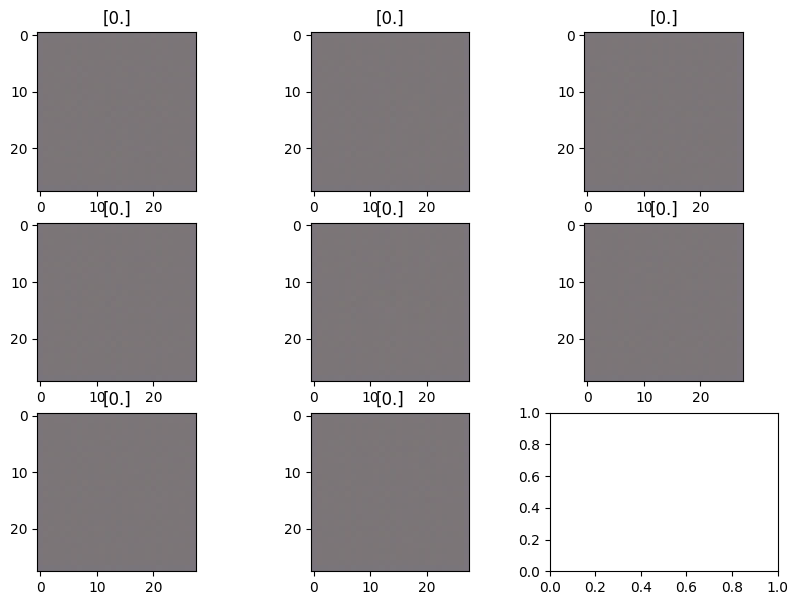

In [15]:
multi_dm = MultiDistillMeDataModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)
multi_dm.on_test_end()